# Visualizing Zebra Herd Behavior

This notebook creates beautiful visualizations of zebra herd behavior metrics computed from unwrapped and cleaned tracking data. It builds on the output of the `clean_unwrapped_tracks.py` notebook.

## Metrics Visualized
- **Herd Polarisation**: How aligned the zebras are in their orientation
- **Movement Speed**: Average speed of individuals in the herd
- **Social Structure**: Inter-zebra distances and nearest neighbors

The visualizations in this notebook are designed to be aesthetically pleasing while conveying clear scientific insights.

## Setup and Data Loading

First, let's import the necessary libraries and set up our visualization environment.

In [2]:
# Import necessary libraries
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
from movement.io import load_poses
from movement.kinematics import compute_pairwise_distances, compute_speed
from movement.transforms import scale
from movement.utils.vector import compute_norm, convert_to_unit
from scipy import stats

In [3]:

# Set up beautiful visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
rcParams['figure.figsize'] = 12, 8
rcParams['figure.dpi'] = 100
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 18
rcParams['font.size'] = 12
rcParams['lines.linewidth'] = 2.0
rcParams['lines.markersize'] = 8
rcParams['legend.fontsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12

# Define a custom color palette for consistency
colors = sns.color_palette("viridis", 8)
zebra_palette = sns.color_palette("rocket", 12)

# Publication-quality figure settings
PUBLICATION_DPI = 300  # High DPI for print quality
FIGURE_DIR = Path("figures")  # Directory to save figures
FIGURE_FORMAT = "pdf"  # Vector format for publication
FIGURE_FORMAT_WEB = "png"  # Raster format for web/presentation

# Function to save figures in publication quality
def save_publication_figure(fig, name, dpi=PUBLICATION_DPI):
    # Save as vector format for publication
    vector_path = FIGURE_DIR / f"{name}.{FIGURE_FORMAT}"
    fig.savefig(vector_path, dpi=dpi, bbox_inches='tight')
    
    # Save as raster format for web/presentation
    raster_path = FIGURE_DIR / f"{name}.{FIGURE_FORMAT_WEB}"
    fig.savefig(raster_path, dpi=dpi, bbox_inches='tight')
    
    print(f"Saved figure to {vector_path} and {raster_path}")


## Load Unwrapped and Cleaned Tracks

We'll work with data processed in the previous notebooks, particularly the cleaned unwrapped tracks.

In [4]:
# Set up the paths
repo_root = Path().absolute()
data_dir = repo_root / "data"
video_dir = repo_root / "videos"
assert data_dir.exists()
assert video_dir.exists()

filename = "20250325_2228_id_unwrapped_20250403_161408_clean_sleap.h5"
file_path = data_dir / filename
video_path = video_dir / "21Jan_007.mp4"
background_path = video_dir / "21Jan_007_unwrapped_background.png"
for path in [file_path, video_path, background_path]:
    assert path.exists()

# Load the cleaned track data
ds = load_poses.from_file(file_path, source_software="SLEAP", fps=30)
print(f"Dataset dimensions: {ds.dims}")
print(f"Number of individuals: {len(ds.individuals)}")
print(f"Number of frames: {len(ds.time)}")
print(f"Keypoints tracked: {', '.join(ds.keypoints.values)}")

Dataset dimensions: FrozenMappingWarningOnValuesAccess({'time': 6294, 'space': 2, 'keypoints': 2, 'individuals': 44})
Number of individuals: 44
Number of frames: 6294
Keypoints tracked: H, T


## Body Length Analysis

We'll analyze the body lengths of zebras to establish a consistent scale for our measurements.

Saved figure to figures/zebra_body_length_distribution.pdf and figures/zebra_body_length_distribution.png


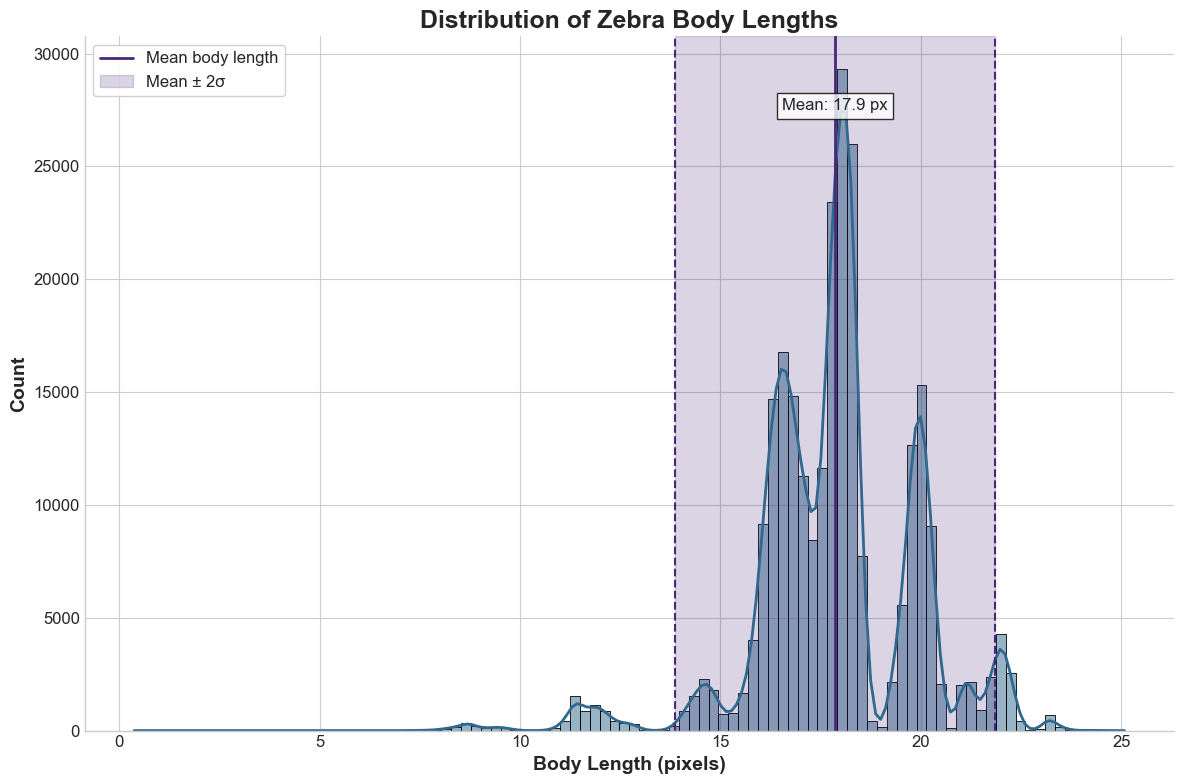

In [5]:
# Calculate body vectors from head to tail positions
body_vector = ds.position.sel(keypoints="H") - ds.position.sel(keypoints="T")
body_length = compute_norm(body_vector)
body_length_std = body_length.std()
body_length_mean = body_length.mean()
body_length_median = body_length.median()

# Create figure for body length distribution
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(body_length.values.flatten(), bins=100, kde=True, color=colors[2], ax=ax)

# Add mean and standard deviation markers
ax.axvline(body_length_mean, color=colors[0], lw=2, linestyle="-", label="Mean body length")
lower_bound = body_length_mean - 2 * body_length_std
upper_bound = body_length_mean + 2 * body_length_std
ax.axvspan(lower_bound, upper_bound, alpha=0.2, color=colors[0], label="Mean ± 2σ")

for bound in [lower_bound, upper_bound]:
    ax.axvline(bound, color=colors[0], lw=1.5, linestyle="--")

# Add annotations
ax.text(body_length_mean, ax.get_ylim()[1]*0.9, f"Mean: {body_length_mean:.1f} px", 
        ha="center", va="center", bbox=dict(facecolor="white", alpha=0.8))

ax.set_xlabel("Body Length (pixels)", fontweight="bold")
ax.set_ylabel("Count", fontweight="bold")
ax.set_title("Distribution of Zebra Body Lengths", fontweight="bold")
ax.legend(frameon=True, fancybox=True, framealpha=0.9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

# Save high resolution version for publication
save_publication_figure(fig, "zebra_body_length_distribution")

In [6]:
# Filter body vectors to remove outliers
body_vector_filtered = body_vector.where(
    np.logical_and(
        body_length <= body_length_mean + 2 * body_length_std,
        body_length >= body_length_mean - 2 * body_length_std,
    )
)

# Compute average body vector per frame
body_vector_avg = body_vector_filtered.mean("individuals")
print(f"Average body vector shape: {body_vector_avg.shape}")

Average body vector shape: (6294, 2)


## Alignment and Herd Polarization

Let's visualize how well the zebras align with each other. Polarization is a measure of the collective alignment of the herd.

Saved figure to figures/zebra_individual_alignment.pdf and figures/zebra_individual_alignment.png


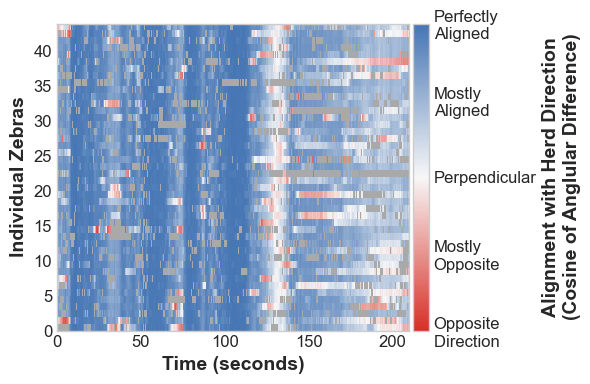

In [7]:
# Compute average unit body vector across all individuals per frame
body_vector_unit_avg = convert_to_unit(body_vector_filtered).mean("individuals")

# Compute dot product between each individual's unit body vector and the average
body_vector_filtered_unit = convert_to_unit(body_vector_filtered)
cos_body_vector = xr.dot(
    body_vector_filtered_unit,
    body_vector_unit_avg,
    dims=["space"],
)

# Create a heatmap of individual alignment over time
fig, ax = plt.subplots(figsize=(6, 4))

# Create a custom diverging colormap (white in center)
alignment_cmap = LinearSegmentedColormap.from_list(
    "alignment_cmap", [(0, "#d73027"), (0.5, "#f7f7f7"), (1.0, "#4575b4")]
)

# Set NaN values to black
cos_body_vector_filled = cos_body_vector.where(~np.isnan(cos_body_vector), other=np.nan)

im = ax.imshow(
    cos_body_vector_filled.values.T,  # Transpose for individuals on y-axis
    aspect="auto",
    cmap=alignment_cmap,
    interpolation="none",
    vmin=-1, vmax=1,
    extent=[cos_body_vector.time[0], cos_body_vector.time[-1], 0, len(cos_body_vector.individuals)]
)

# Overlay black for NaN values
im.cmap.set_bad(color='darkgray')

# Create a more informative colorbar
cbar = plt.colorbar(im, ax=ax, pad=0.01)
cbar.set_label("Alignment with Herd Direction\n(Cosine of Anglular Difference)", fontsize=14, fontweight="bold")
cbar.set_ticks([-1, -0.5, 0, 0.5, 1])

cbar.set_ticklabels(["Opposite\nDirection ", "Mostly\nOpposite", "Perpendicular", "Mostly\nAligned", "Perfectly\nAligned"])

# Set x-axis labels to show time in seconds
ax.set_xlabel("Time (seconds)", fontsize=14, fontweight="bold")
ax.set_ylabel("Individual Zebras", fontsize=14, fontweight="bold")
# Add ticks to cbar and labels for 
# ax.set_xticks(np.linspace(cos_body_vector.time[0], cos_body_vector.time[-1]))

# Add grid for better readability
ax.grid(False)
plt.tight_layout()

# Save high resolution version for publication
save_publication_figure(fig, "zebra_individual_alignment")


Saved figure to figures/zebra_herd_polarization.pdf and figures/zebra_herd_polarization.png


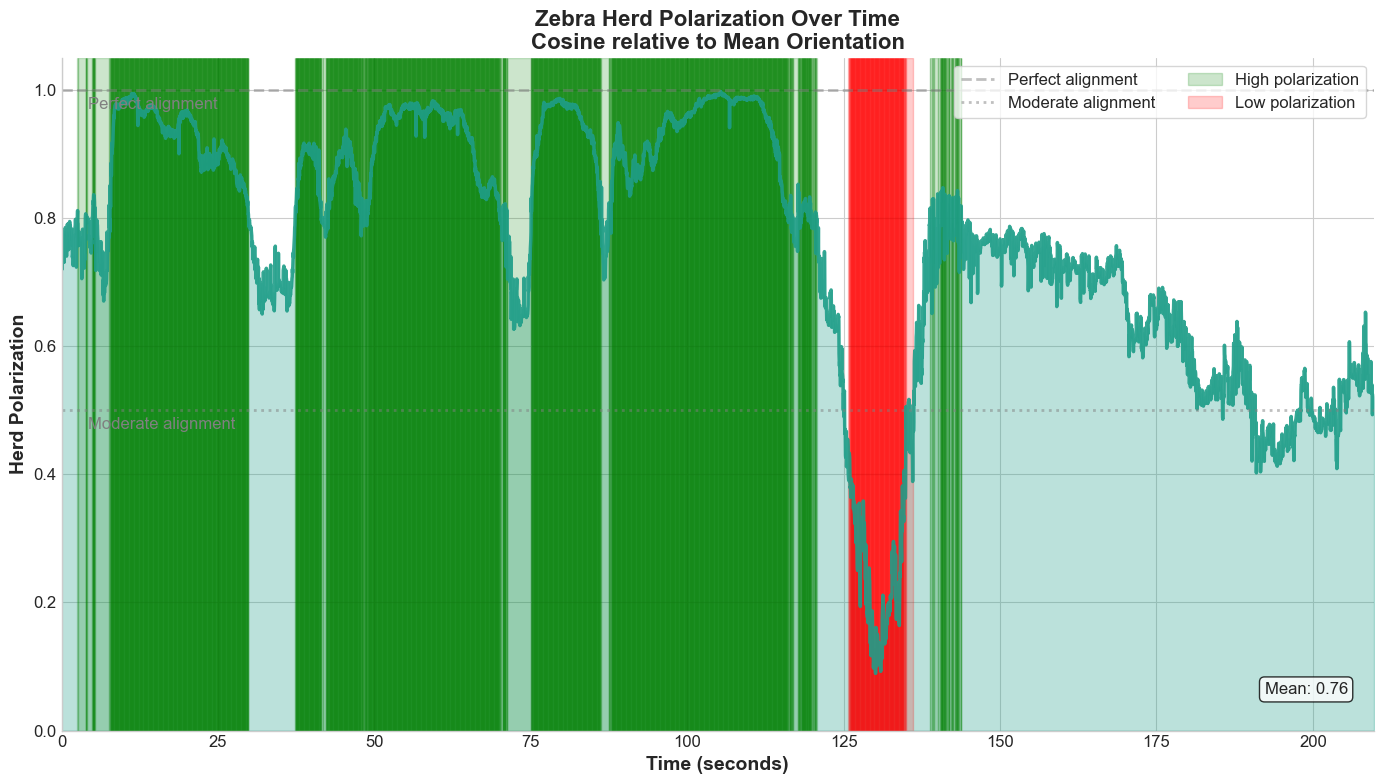

In [8]:
# Compute the herd's polarisation
polarisation = compute_norm(body_vector_unit_avg)
polarisation.name = "Herd Polarization"

# Create a beautiful time series plot of polarization
fig, ax = plt.subplots(figsize=(14, 8))

# Plot with gradient fill
ax.plot(polarisation.time, polarisation, lw=2.5, color=colors[4], alpha=0.9)
ax.fill_between(polarisation.time, 0, polarisation, alpha=0.3, color=colors[4])

# Add horizontal lines for reference
ax.axhline(y=1, color='gray', linestyle='--', alpha=0.5, label="Perfect alignment")
ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, label="Moderate alignment")

# Highlight interesting regions (high and low polarization)
high_polar = polarisation > 0.8
low_polar = polarisation < 0.4

# Simplified legend for high/low polarization regions
high_patch = plt.Rectangle((0,0), 1, 1, color='green', alpha=0.2, label="High polarization")
low_patch = plt.Rectangle((0,0), 1, 1, color='red', alpha=0.2, label="Low polarization")

# Now add the spans without adding to legend
if high_polar.any():
    high_times = polarisation.time.where(high_polar, drop=True)
    for start, end in zip(high_times[:-1], high_times[1:]):
        if end - start <= 5:  # Only highlight continuous regions
            ax.axvspan(start, end, alpha=0.2, color='green', label="_nolegend_")
                
if low_polar.any():
    low_times = polarisation.time.where(low_polar, drop=True)
    for start, end in zip(low_times[:-1], low_times[1:]):
        if end - start <= 5:  # Only highlight continuous regions
            ax.axvspan(start, end, alpha=0.2, color='red', label="_nolegend_")

ax.set_ylim(0, 1.05)
ax.set_xlim(polarisation.time[0], polarisation.time[-1])
ax.set_xlabel("Time (seconds)", fontsize=14, fontweight="bold")
ax.set_ylabel("Herd Polarization", fontsize=14, fontweight="bold")
ax.set_title("Zebra Herd Polarization Over Time\nCosine relative to Mean Orientation", fontsize=16, fontweight="bold")

# Add simple annotation for reference lines
ax.text(polarisation.time[-1]*0.02, 0.97, "Perfect alignment", color="gray", ha="left")
ax.text(polarisation.time[-1]*0.02, 0.47, "Moderate alignment", color="gray", ha="left")

# Add a simplified stats text - just the mean
mean_pol = float(polarisation.mean())
ax.text(0.98, 0.05, f"Mean: {mean_pol:.2f}", transform=ax.transAxes,
        ha="right", va="bottom", fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Add only essential items to the legend
handles, labels = ax.get_legend_handles_labels()
handles.extend([high_patch, low_patch])  # Add our custom patches
labels.extend(["High polarization", "Low polarization"])
ax.legend(handles=handles, labels=labels, loc="upper right", frameon=True, ncol=2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

# Save high resolution version for publication
save_publication_figure(fig, "zebra_herd_polarization")

## Speed Analysis

Now, let's analyze the movement speed of the zebra herd and see how it relates to polarization.

Saved figure to figures/zebra_speed_and_polarization.pdf and figures/zebra_speed_and_polarization.png


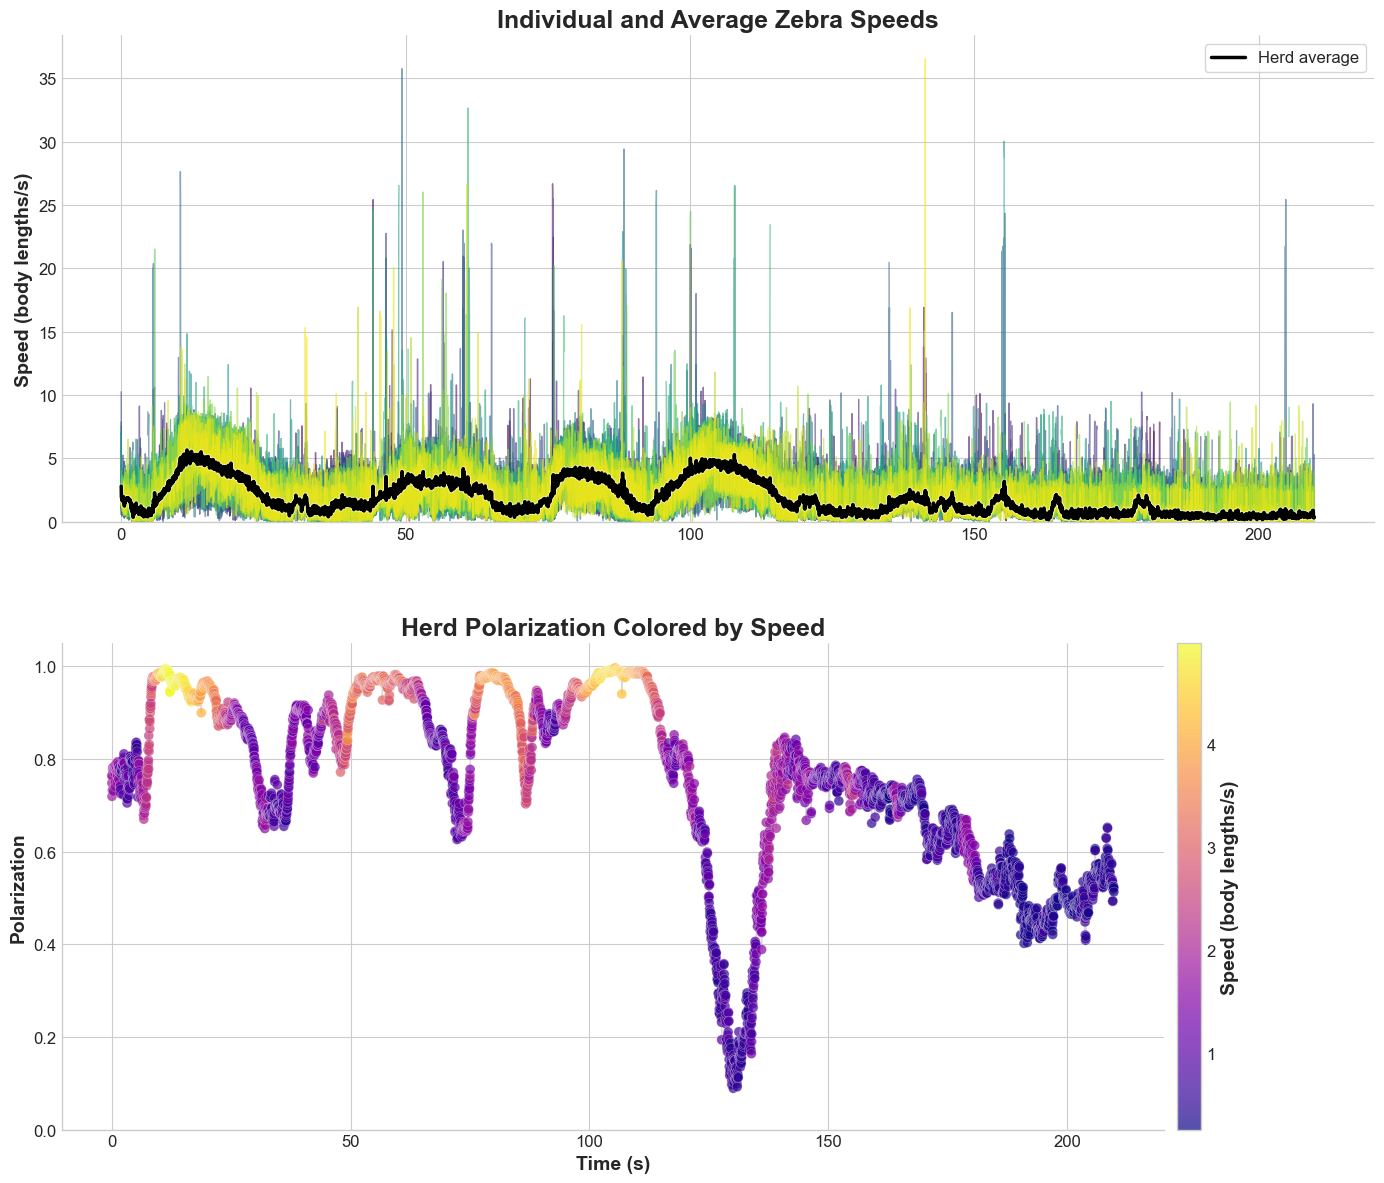

In [9]:
# Scale the position data by body length
position_scaled = scale(
    ds.position, factor=1 / body_length_median.item(), space_unit="body_length"
)

# Compute speed of each zebra's centroid
centroid = position_scaled.mean("keypoints")
speed = compute_speed(centroid)
speed_avg = speed.mean("individuals")
speed_avg.name = "Average speed (body lengths/s)"
log10_speed_avg = np.log10(speed_avg.where(speed_avg > 0.01))
log10_speed_avg.name = "log10 Average speed (body lengths/s)"

# Create a dual visualization of speed
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [1, 1]})

# PLOT 1: Individual speeds as stacked lines
cmap = plt.cm.viridis
for i, ind in enumerate(speed.individuals):
    color = cmap(i / len(speed.individuals))
    ax1.plot(speed.time, speed.sel(individuals=ind), color=color, lw=1, alpha=0.6)

# Plot average speed with thicker line
ax1.plot(speed_avg.time, speed_avg, color="white", lw=4, alpha=0.5)
ax1.plot(speed_avg.time, speed_avg, color="black", lw=2.5, label="Herd average")

ax1.set_ylabel("Speed (body lengths/s)", fontsize=14, fontweight="bold")
ax1.set_title("Individual and Average Zebra Speeds", fontsize=18, fontweight="bold")
ax1.legend(frameon=True, loc="upper right")
ax1.set_ylim(bottom=0)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# PLOT 2: Polarization colored by speed
sc = ax2.scatter(
    x=polarisation.time,
    y=polarisation,
    c=speed_avg,
    s=50,
    cmap="plasma",
    vmin=speed_avg.quantile(0.01).item(),
    vmax=speed_avg.quantile(0.99).item(),
    edgecolor="white",
    linewidth=0.2,
    alpha=0.7
)

# Add connecting line for visual continuity
ax2.plot(polarisation.time, polarisation, color="gray", lw=1, alpha=0.3, zorder=0)

cbar = plt.colorbar(sc, ax=ax2, pad=0.01)
cbar.set_label("Speed (body lengths/s)", fontsize=14, fontweight="bold")

ax2.set_xlabel("Time (s)", fontsize=14, fontweight="bold")
ax2.set_ylabel("Polarization", fontsize=14, fontweight="bold")
ax2.set_title("Herd Polarization Colored by Speed", fontsize=18, fontweight="bold")
ax2.set_ylim(0, 1.05)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(hspace=0.25)

# Save high resolution version for publication
save_publication_figure(fig, "zebra_speed_and_polarization")

## Relationship Between Speed and Polarization

Let's explore the relationship between herd movement speed and polarization.

Saved figure to figures/zebra_speed_polarization_relationship.pdf and figures/zebra_speed_polarization_relationship.png


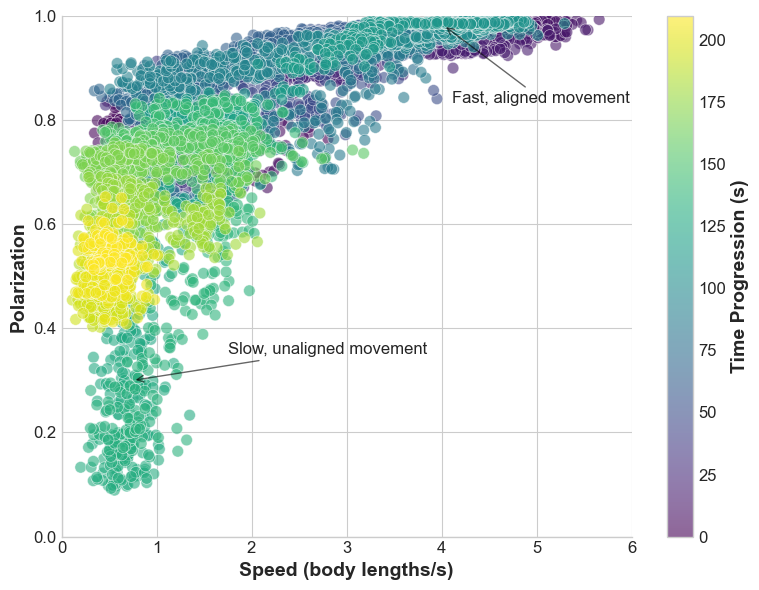

In [10]:
# Create a scatter plot of polarization vs speed
fig, ax = plt.subplots(figsize=(8, 6))

# Define a custom colormap based on density
n_points = len(speed_avg)
point_colors = np.linspace(0, 1, n_points)
# Time in seconds
point_colors = polarisation.time.values

# Create a cleaner scatter plot
scatter = ax.scatter(speed_avg, polarisation, 
                     c=point_colors, 
                     cmap="viridis", 
                     s=70, 
                     alpha=0.6,
                     edgecolors='white',
                     linewidth=0.5)

# Add a best fit line without legend clutter
# valid_idx = ~np.isnan(speed_avg) & ~np.isnan(polarisation)
# x = speed_avg.values[valid_idx]
# y = polarisation.values[valid_idx]
# z = np.polyfit(x, y, 1)
# p = np.poly1d(z)
# x_range = np.linspace(min(x), max(x), 100)
# ax.plot(x_range, p(x_range), '--', color="#cc0000", lw=2)

# Add just the correlation value
# corr = np.corrcoef(x, y)[0, 1]
# ax.text(0.05, 0.95, f"Correlation: {corr:.3f}", transform=ax.transAxes, 
#         bbox=dict(facecolor='white', alpha=0.8), fontsize=12)

# Simplified colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Time Progression (s)", fontsize=14, fontweight="bold")

ax.set_xlabel("Speed (body lengths/s)", fontsize=14, fontweight="bold")
ax.set_ylabel("Polarization", fontsize=14, fontweight="bold")
# ax.set_title("Relationship Between Herd Speed and Polarization", fontsize=18, fontweight="bold")

# Label just key regions for clarity
# Find a single representative point for high speed/high polarization
high_speed_high_pol = (speed_avg > speed_avg.quantile(0.9)) & (polarisation > 0.9)
if high_speed_high_pol.any():
    idx = np.where(high_speed_high_pol)[0][0]
    ax.annotate("Fast, aligned movement", 
                xy=(speed_avg.values[idx], polarisation.values[idx]),
                xytext=(speed_avg.values[idx]+0.09, polarisation.values[idx]-0.15),
                arrowprops=dict(arrowstyle="->", color='black', alpha=0.6))

# Find a representative point for slow, unaligned movement
# slow_speed_low_pol = (speed_avg < speed_avg.quantile(0.1)) & (polarisation < 0.3)
# idx = np.where(slow_speed_low_pol)[0][0]
ax.annotate("Slow, unaligned movement", 
            xy=(0.75, 0.3),
            xytext=(0.75+1, 0.3+0.05),
            arrowprops=dict(arrowstyle="->", color='black', alpha=0.6))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.xlim(0, 6)
plt.ylim(0, 1.0)

# Save high resolution version for publication
save_publication_figure(fig, "zebra_speed_polarization_relationship")

## Inter-Zebra Distances

Now, let's analyze the spatial relationships between zebras in the herd.

Saved figure to figures/zebra_pairwise_distances.pdf and figures/zebra_pairwise_distances.png
Saved figure to figures/zebra_distances_and_polarization.pdf and figures/zebra_distances_and_polarization.png


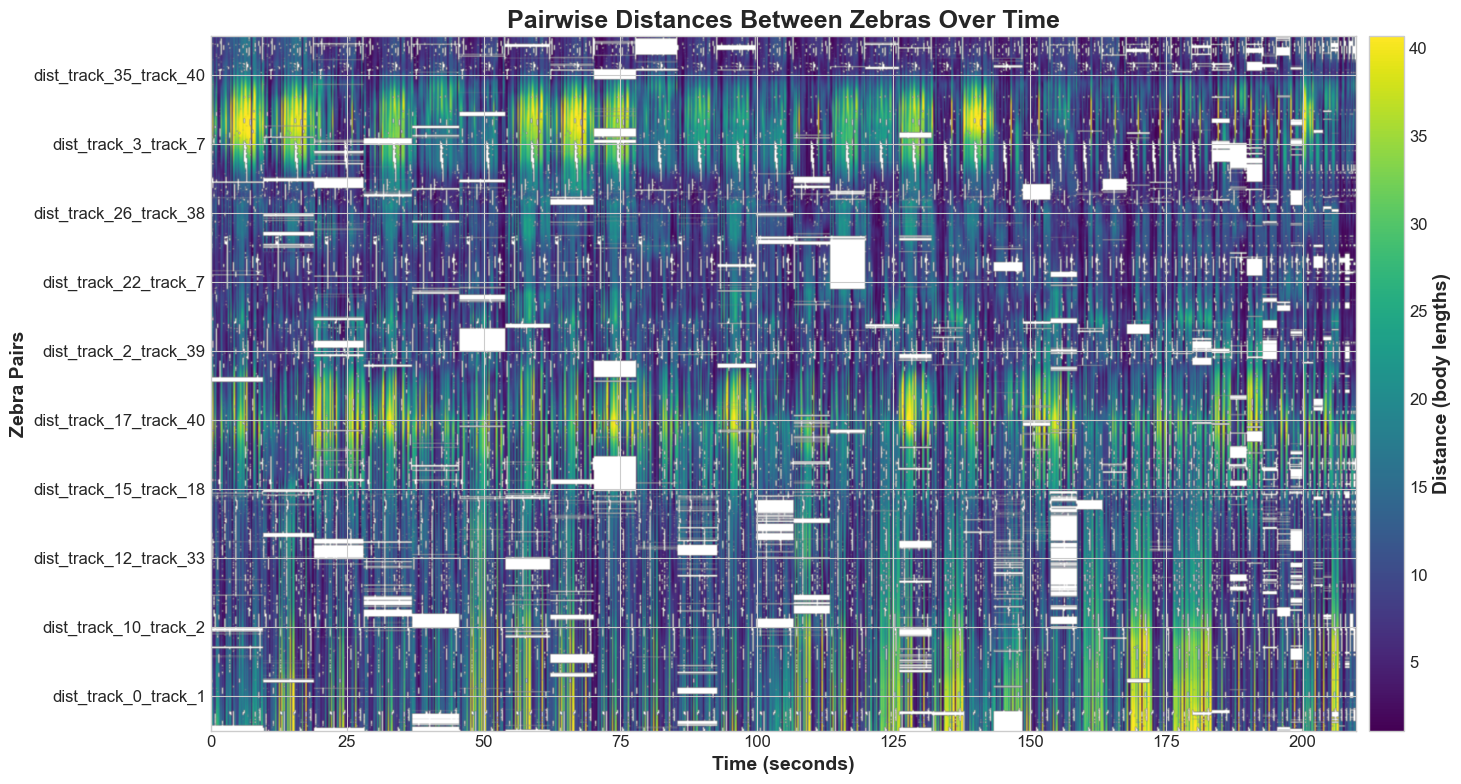

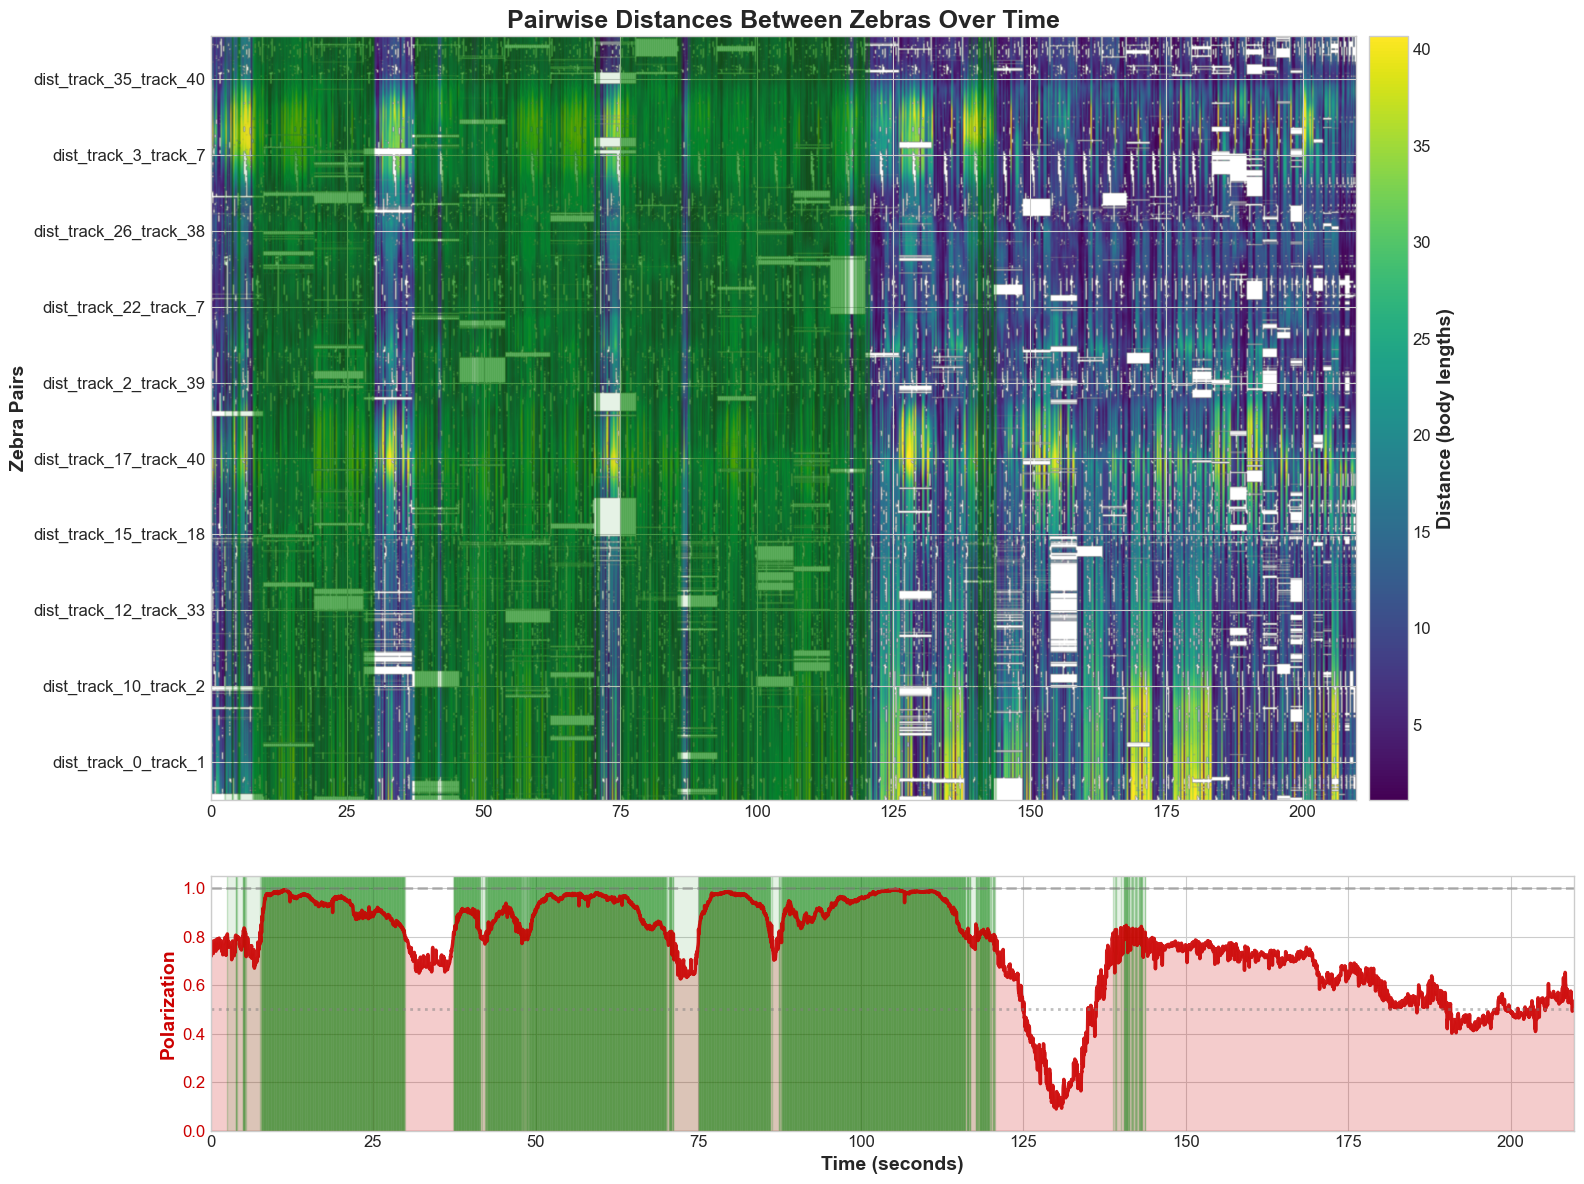

In [11]:
# Compute pairwise distances
distances_dict = compute_pairwise_distances(
    centroid,
    dim="individuals",
    pairs="all",
    metric="euclidean",
)

# Stack the dict into a data array
distances = xr.concat(
    distances_dict.values(),
    dim="id_pair",
)
distances = distances.assign_coords(id_pair=list(distances_dict.keys()))
distances.name = "Distance (body lengths)"

# Create separate figures for distances and polarization
fig, ax = plt.subplots(figsize=(16, 8))

# Use a custom colormap for the heatmap
distance_cmap = plt.cm.viridis

im = ax.imshow(
    distances.T,  # Transpose for better visual
    aspect="auto",
    cmap=distance_cmap,
    interpolation="bicubic",
    vmin=distances.quantile(0.01),
    vmax=distances.quantile(0.99),
    extent=[distances.time[0], distances.time[-1], 0, len(distances.id_pair)]
)

cbar = plt.colorbar(im, ax=ax, pad=0.01)
cbar.set_label("Distance (body lengths)", fontsize=14, fontweight="bold")

# Fix the y-axis tick and label mismatch
n_pairs = len(distances.id_pair)
step = max(1, n_pairs // 10)  # Show at most 10 labels
y_positions = np.arange(step/2, n_pairs, step)
y_labels = [distances.id_pair.values[int(i)] for i in np.arange(0, n_pairs, step)]
ax.set_yticks(y_positions)
ax.set_yticklabels(y_labels[:len(y_positions)])

ax.set_xlabel("Time (seconds)", fontsize=14, fontweight="bold")
ax.set_ylabel("Zebra Pairs", fontsize=14, fontweight="bold")
ax.set_title("Pairwise Distances Between Zebras Over Time", fontsize=18, fontweight="bold")
plt.tight_layout()

# Save high resolution version for publication
save_publication_figure(fig, "zebra_pairwise_distances")

# Create a separate figure with distances and polarization overlay
# This allows better visualization of both metrics without cluttering
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [3, 1]})

# Plot distances in the main panel
im = ax1.imshow(
    distances.T,
    aspect="auto",
    cmap=distance_cmap,
    interpolation="bicubic",
    vmin=distances.quantile(0.01),
    vmax=distances.quantile(0.99),
    extent=[distances.time[0], distances.time[-1], 0, len(distances.id_pair)]
)

# Fix the y-axis tick and label mismatch
ax1.set_yticks(y_positions)
ax1.set_yticklabels(y_labels[:len(y_positions)])
ax1.set_ylabel("Zebra Pairs", fontsize=14, fontweight="bold")
ax1.set_title("Pairwise Distances Between Zebras Over Time", fontsize=18, fontweight="bold")

# Add colorbar
cbar = plt.colorbar(im, ax=ax1, pad=0.01)
cbar.set_label("Distance (body lengths)", fontsize=14, fontweight="bold")

# Plot polarization in the lower panel for comparison
ax2.plot(polarisation.time, polarisation, color='#cc0000', lw=2.5, alpha=0.9)
ax2.fill_between(polarisation.time, 0, polarisation, alpha=0.2, color='#cc0000')

# Add reference lines
ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax2.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)

ax2.set_ylim(0, 1.05)
ax2.set_xlim(polarisation.time[0], polarisation.time[-1])
ax2.set_xlabel("Time (seconds)", fontsize=14, fontweight="bold")
ax2.set_ylabel("Polarization", fontsize=14, fontweight="bold", color='#cc0000')
ax2.tick_params(axis='y', colors='#cc0000')

# Connect the two plots with shading for important events
high_polar = polarisation > 0.8
if high_polar.any():
    high_times = polarisation.time.where(high_polar, drop=True)
    for start, end in zip(high_times[:-1], high_times[1:]):
        if end - start <= 5:  # Only highlight continuous regions
            # Highlight in both plots
            ax1.axvspan(start, end, alpha=0.1, color='green')
            ax2.axvspan(start, end, alpha=0.1, color='green')

plt.tight_layout()
plt.subplots_adjust(hspace=0.15)

# Save high resolution version for publication
save_publication_figure(fig, "zebra_distances_and_polarization")

## Average Inter-Individual Distance

Let's calculate and visualize the average distance between zebras, which is a key metric for social cohesion.

Saved figure to figures/zebra_herd_cohesion.pdf and figures/zebra_herd_cohesion.png
Saved figure to figures/zebra_cohesion_polarization_comparison.pdf and figures/zebra_cohesion_polarization_comparison.png


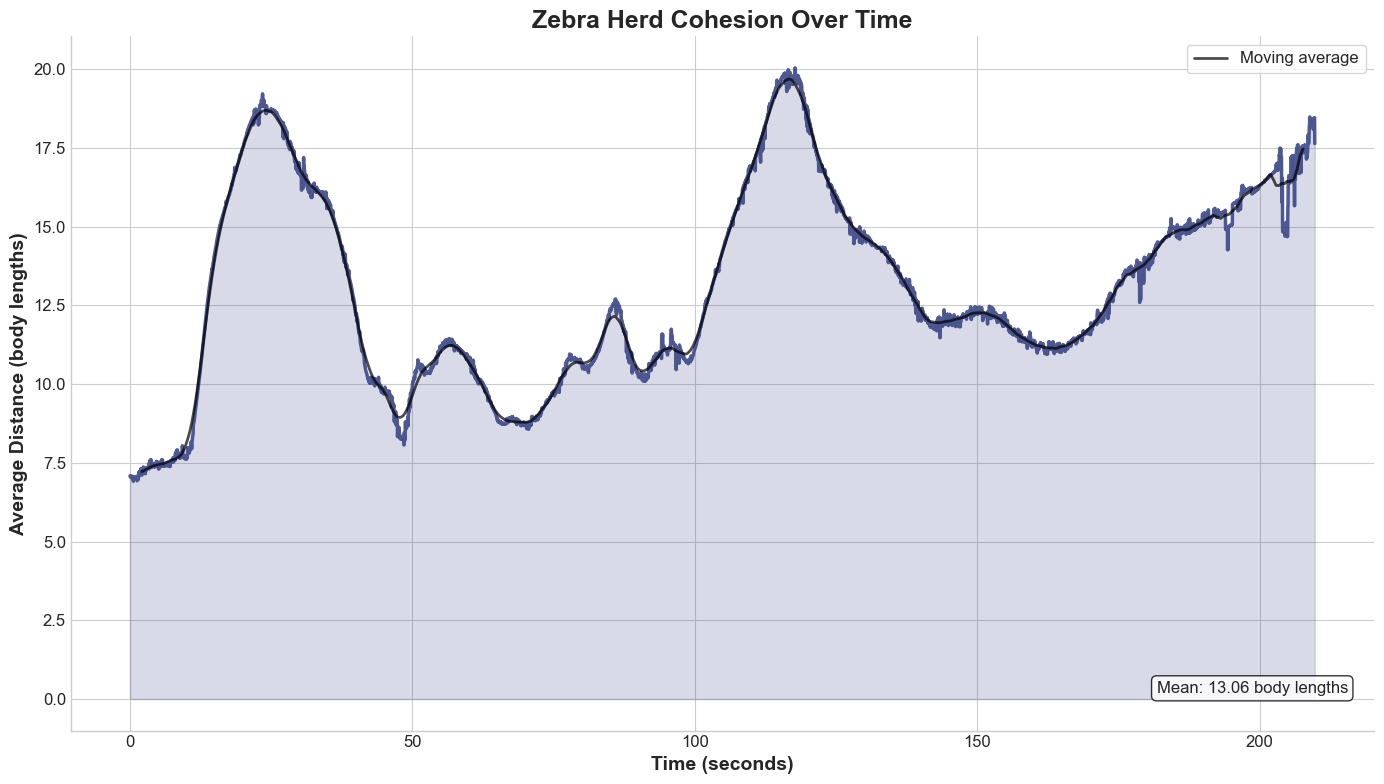

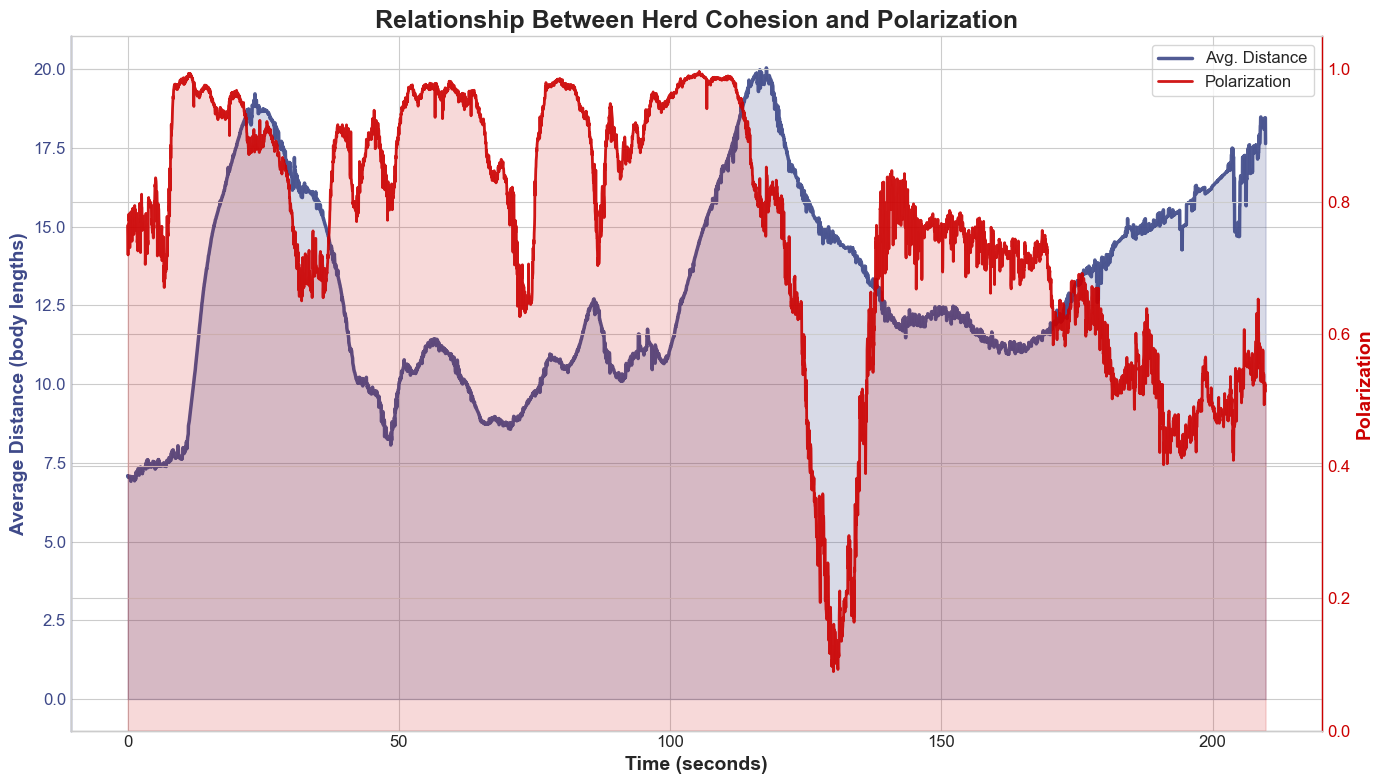

In [12]:
# Calculate mean distance across all pairs for each time point
mean_distance = distances.mean("id_pair")
mean_distance.name = "Average Inter-Individual Distance"

# Create a clean, simplified visualization of average distances
fig, ax = plt.subplots(figsize=(14, 8))

# Main plot: Average distance with gradient fill
ax.plot(mean_distance.time, mean_distance, lw=2.5, color=colors[1], alpha=0.9)
ax.fill_between(mean_distance.time, 0, mean_distance, alpha=0.2, color=colors[1])

# Just add a simple moving average trend line without excessive statistics
window_size = max(3, len(mean_distance) // 50)
rolling_mean = mean_distance.rolling(time=window_size, center=True).mean()
ax.plot(rolling_mean.time, rolling_mean, lw=2, color='black', alpha=0.7, label=f"Moving average")

# Add only the mean as a simple statistic
mean_val = float(mean_distance.mean())
ax.text(0.98, 0.05, f"Mean: {mean_val:.2f} body lengths", transform=ax.transAxes,
        ha="right", va="bottom", fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Beautify
ax.set_xlabel("Time (seconds)", fontsize=14, fontweight="bold")
ax.set_ylabel("Average Distance (body lengths)", fontsize=14, fontweight="bold")
ax.set_title("Zebra Herd Cohesion Over Time", fontsize=18, fontweight="bold")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc="upper right", frameon=True)
plt.tight_layout()

# Save high resolution version for publication
save_publication_figure(fig, "zebra_herd_cohesion")

# Second figure: Mean distance and polarization combined with minimal clutter
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot mean distance on primary y-axis
ax1.plot(mean_distance.time, mean_distance, lw=2.5, color=colors[1], alpha=0.9, label="Avg. Distance")
ax1.fill_between(mean_distance.time, 0, mean_distance, alpha=0.2, color=colors[1])
ax1.set_xlabel("Time (seconds)", fontsize=14, fontweight="bold")
ax1.set_ylabel("Average Distance (body lengths)", fontsize=14, fontweight="bold", color=colors[1])
ax1.tick_params(axis='y', colors=colors[1])
ax1.spines['left'].set_color(colors[1])

# Add polarization on secondary y-axis with increased spacing
ax2 = ax1.twinx()
ax2.plot(polarisation.time, polarisation, color='#cc0000', lw=2, alpha=0.9, label="Polarization")
ax2.fill_between(polarisation.time, 0, polarisation, alpha=0.15, color='#cc0000')
ax2.set_ylim(0, 1.05)
ax2.set_ylabel("Polarization", fontsize=14, fontweight="bold", color='#cc0000')
ax2.tick_params(axis='y', colors='#cc0000')
ax2.spines['right'].set_color('#cc0000')

# Clean legend with just the essential information
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', frameon=True)

ax1.set_title("Relationship Between Herd Cohesion and Polarization", fontsize=18, fontweight="bold")
ax1.spines['top'].set_visible(False)
plt.tight_layout()

# Save high resolution version for publication
save_publication_figure(fig, "zebra_cohesion_polarization_comparison")

## Nearest Neighbor Analysis

Let's analyze nearest neighbor relationships to understand the fine-grained social structure.

Saved figure to figures/zebra_nearest_neighbors.pdf and figures/zebra_nearest_neighbors.png


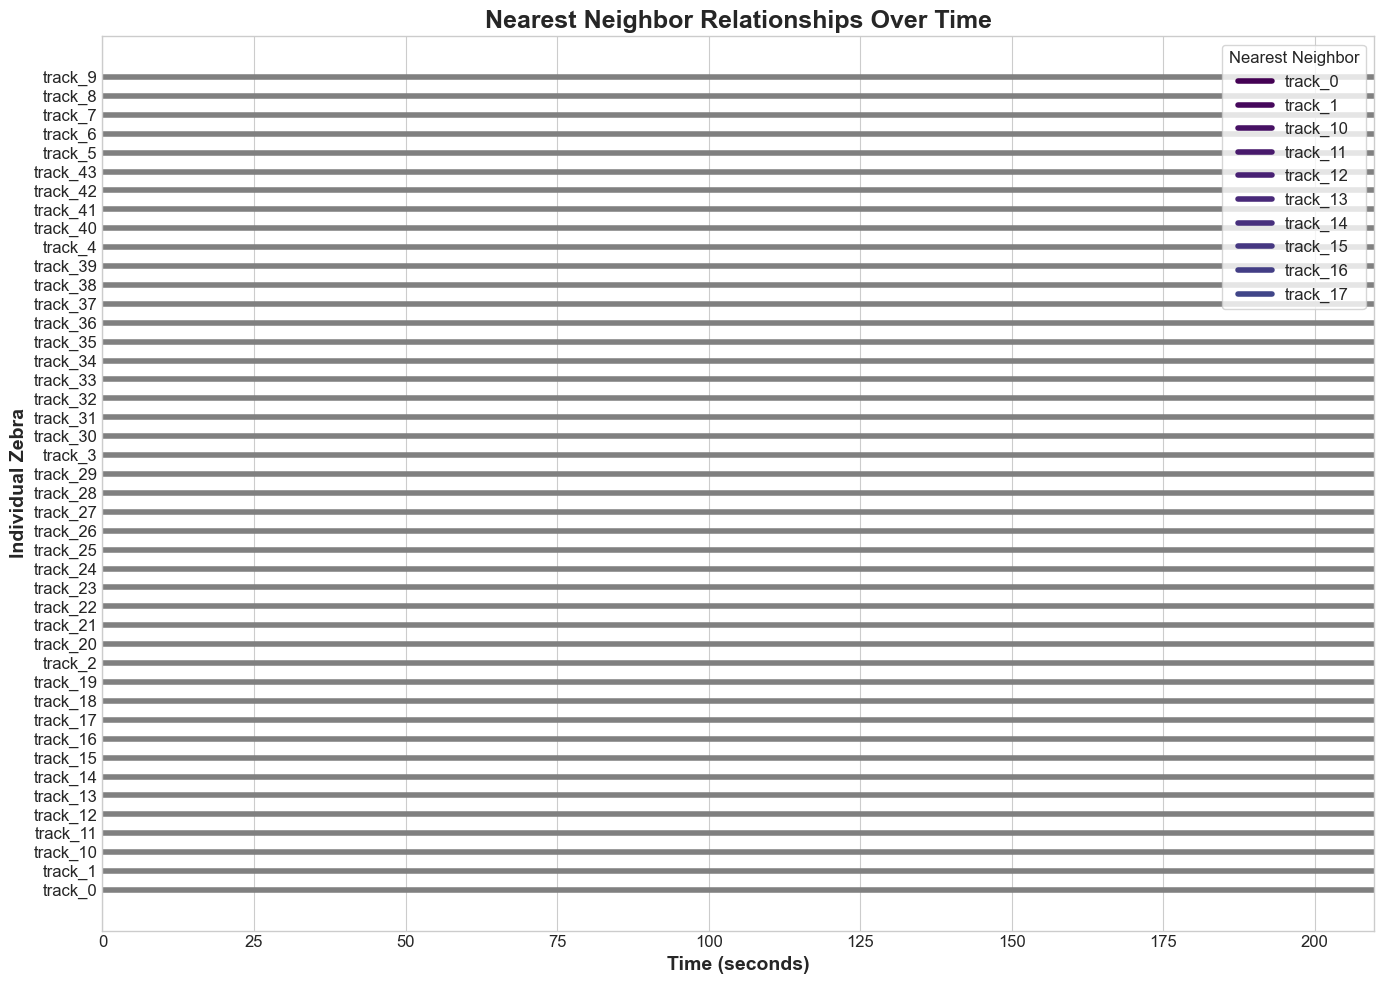

In [13]:
# Calculate nearest neighbor for each zebra at each time point
min_distances = {}
nearest_neighbors = {}

# For each individual, find its minimum distance to others
for individual in centroid.individuals.values:
    # Get all distance arrays where this individual is involved
    ind_distances = []
    ind_pairs = []
    
    for pair, dist in distances_dict.items():
        if individual in pair:
            other_ind = pair[1] if pair[0] == individual else pair[0]
            ind_distances.append(dist)
            ind_pairs.append(other_ind)
    
    if ind_distances:  # If we have distances for this individual
        # Stack the arrays
        stacked = xr.concat(ind_distances, dim="neighbor")
        stacked = stacked.assign_coords(neighbor=ind_pairs)
        
        # Find minimum distance at each time point
        min_dist = stacked.min(dim="neighbor")
        min_distances[individual] = min_dist
        
        # Find which neighbor is closest at each time point
        # Handle the All-NaN slice encountered issue
        try:
            closest_idx = stacked.argmin(dim="neighbor")
            nn_values = [stacked.neighbor.values[int(idx)] for idx in closest_idx.values]
        except ValueError as e:
            if "All-NaN slice encountered" in str(e):
                # For time points with all NaN, use the first neighbor as a fallback
                # or we could use np.full to create an array of NaN or a specific value
                closest_idx = xr.zeros_like(stacked.isel(neighbor=0), dtype=int)
                nn_values = [stacked.neighbor.values[0]] * len(stacked.time)
            else:
                raise  # Re-raise if it's a different error
        
        nearest_neighbors[individual] = xr.DataArray(
            nn_values,
            coords={"time": stacked.time},
            dims=["time"]
        )

# Create a visualization of nearest neighbor relationships
fig, ax = plt.subplots(figsize=(14, 10))

# Set up a colormap for individuals
individuals = sorted(centroid.individuals.values)
n_individuals = len(individuals)
ind_cmap = plt.cm.tab20 if n_individuals <= 20 else plt.cm.viridis

# Create color dictionary for individuals
ind_colors = {ind: ind_cmap(i/n_individuals) for i, ind in enumerate(individuals)}

# For each individual, plot its nearest neighbor over time
for i, ind in enumerate(individuals):
    if ind not in nearest_neighbors:
        continue
        
    nn_data = nearest_neighbors[ind]
    time_vals = nn_data.time.values
    
    # Find contiguous segments with the same nearest neighbor
    current_nn = nn_data.values[0]
    segment_start = time_vals[0]
    
    for t_idx, t in enumerate(time_vals):
        nn = nn_data.values[t_idx]
        
        if nn != current_nn or t_idx == len(time_vals) - 1:
            # Plot the segment
            segment_end = t if nn != current_nn else time_vals[-1]
            color = ind_colors.get(current_nn, 'gray')
            
            ax.plot([segment_start, segment_end], [i, i], lw=4, color=color, solid_capstyle='butt')
            
            # Start a new segment
            segment_start = t
            current_nn = nn

# Add y-axis labels for individuals
ax.set_yticks(range(len(individuals)))
ax.set_yticklabels(individuals)

# Add a legend for individuals
for i, ind in enumerate(individuals[:10]):  # Limit to 10 in legend for clarity
    ax.plot([], [], lw=4, color=ind_colors[ind], label=ind)

# Customize the plot
ax.set_xlabel("Time (seconds)", fontsize=14, fontweight="bold")
ax.set_ylabel("Individual Zebra", fontsize=14, fontweight="bold")
ax.set_title("Nearest Neighbor Relationships Over Time", fontsize=18, fontweight="bold")
ax.legend(title="Nearest Neighbor", loc="upper right", frameon=True)

# Set x-axis limits
ax.set_xlim(min(distances.time.values), max(distances.time.values))

# Add grid for visual guidance
ax.grid(True, axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()

# Save high resolution version for publication
save_publication_figure(fig, "zebra_nearest_neighbors")

## Alignment by Distance from Herd Centroid

Let's analyze how a zebra's alignment with the herd direction correlates with its distance from the herd centroid on a frame-by-frame basis. This analysis helps understand whether peripheral animals tend to be more or less aligned with the group than those near the center.

Saved figure to figures/zebra_alignment_by_centroid_distance.pdf and figures/zebra_alignment_by_centroid_distance.png


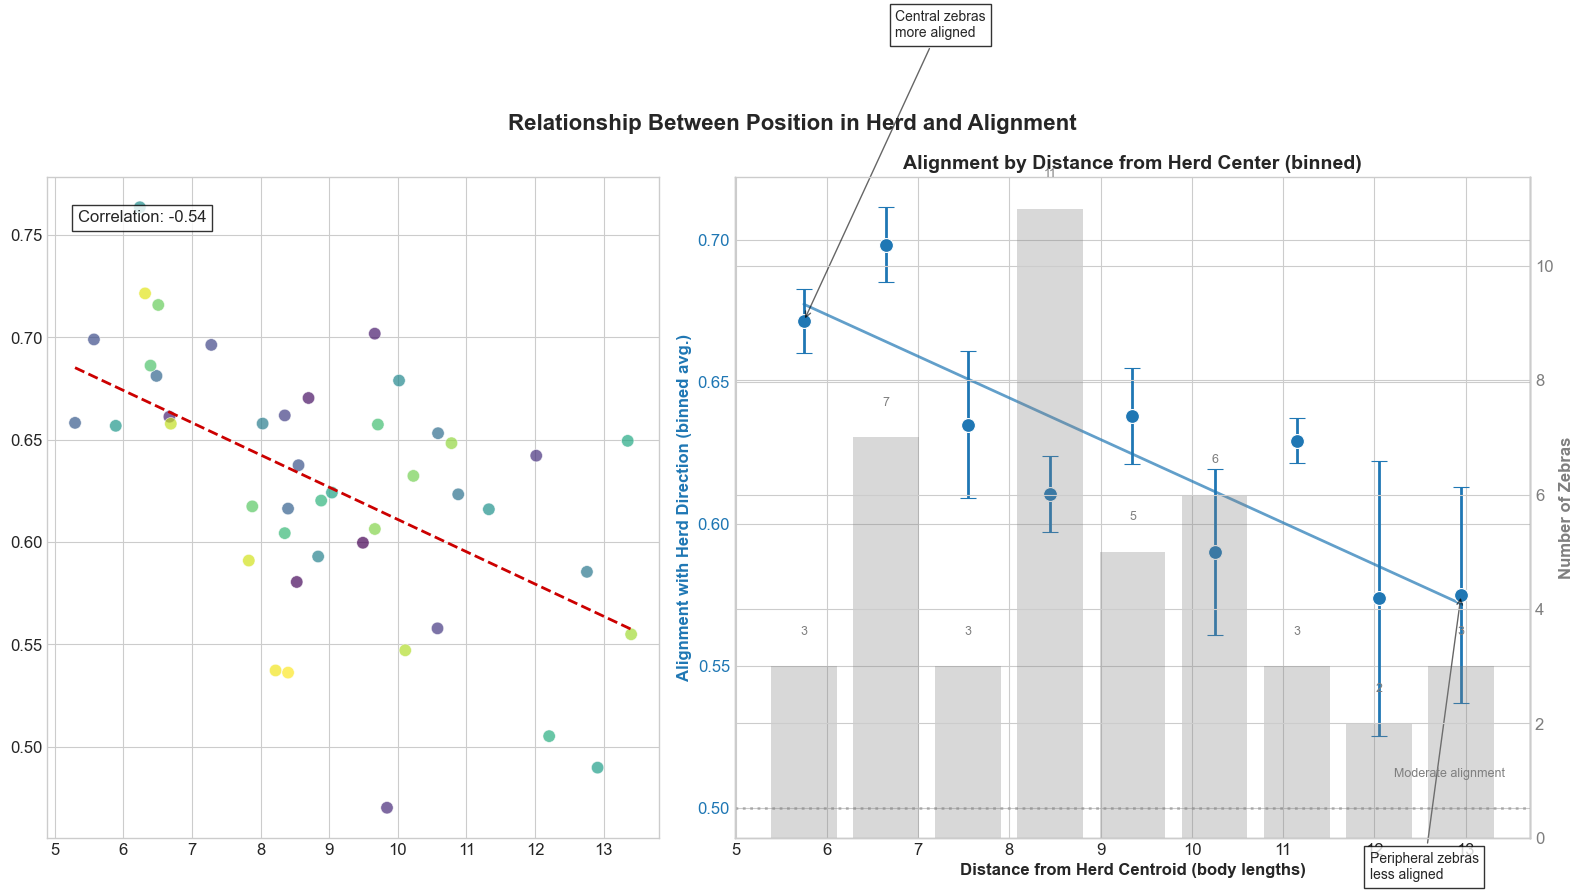

In [14]:
# Calculate the centroid of the entire herd for each frame
herd_centroid = centroid.mean("individuals")

# Compute distance of each individual from the herd centroid
distance_from_centroid = xr.zeros_like(centroid.isel(space=0))

# For each individual, calculate distance from herd centroid
for i, ind in enumerate(centroid.individuals.values):
    # Get position of this individual
    ind_position = centroid.sel(individuals=ind)
    
    # Calculate squared differences along space dimension
    squared_diffs = (ind_position - herd_centroid)**2
    
    # Sum across space dimension and take square root for Euclidean distance
    distances = np.sqrt(squared_diffs.sum(dim="space"))
    
    # Store in the result array
    distance_from_centroid.loc[dict(individuals=ind)] = distances

# Average distance from centroid over time for each individual
avg_distance_from_centroid = distance_from_centroid.mean("time")

# Average alignment (dot product with herd direction) over time for each individual
avg_alignment = cos_body_vector.mean("time")

# Calculate mean and standard error for binned distances
# We'll group zebras by their average distance from centroid
distance_bins = np.linspace(avg_distance_from_centroid.min().item(), avg_distance_from_centroid.max().item(), 10)
bin_midpoints = (distance_bins[:-1] + distance_bins[1:]) / 2

alignment_by_bin = []
alignment_stderr_by_bin = []
count_by_bin = []

for i in range(len(distance_bins) - 1):
    in_bin = (avg_distance_from_centroid >= distance_bins[i]) & (avg_distance_from_centroid < distance_bins[i+1])
    if in_bin.any():
        alignments = avg_alignment.where(in_bin, drop=True)
        alignment_by_bin.append(alignments.mean().item())
        alignment_stderr_by_bin.append(alignments.std().item() / np.sqrt(len(alignments)))
        count_by_bin.append(len(alignments))
    else:
        alignment_by_bin.append(np.nan)
        alignment_stderr_by_bin.append(np.nan)
        count_by_bin.append(0)

# Create a sophisticated dual-panel figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 1.3]})

# First panel: Scatter plot of individual points
scatter = ax1.scatter(
    avg_distance_from_centroid,
    avg_alignment,
    c=np.arange(len(avg_alignment)),  # Color by individual for visual distinction
    cmap='viridis',
    s=80,
    alpha=0.7,
    edgecolor='white',
    linewidth=0.5,
)

# Add a linear trend line
valid_idx = ~np.isnan(avg_distance_from_centroid) & ~np.isnan(avg_alignment)
x_valid = avg_distance_from_centroid.values[valid_idx]
y_valid = avg_alignment.values[valid_idx]

if len(x_valid) > 2:
    z = np.polyfit(x_valid, y_valid, 1)
    p = np.poly1d(z)
    x_range = np.linspace(min(x_valid), max(x_valid), 100)
    ax1.plot(x_range, p(x_range), '--', color='#cc0000', lw=2)

    # Add correlation coefficient
    corr = np.corrcoef(x_valid, y_valid)[0, 1]
    ax1.text(
        0.05, 0.95,
        f"Correlation: {corr:.2f}",
        transform=ax1.transAxes,
        ha="left", va="top",
        bbox=dict(facecolor="white", alpha=0.8)
    )

# Second panel: Binned averages with error bars
ax2.errorbar(
    bin_midpoints,
    alignment_by_bin,
    yerr=alignment_stderr_by_bin,
    fmt='o',
    color='#1f77b4',
    markersize=10,
    capsize=6,
    elinewidth=2,
    markeredgecolor='white',
    markeredgewidth=0.8,
)

# Add secondary y-axis for count per bin
ax3 = ax2.twinx()
bars = ax3.bar(
    bin_midpoints,
    count_by_bin,
    width=(distance_bins[1] - distance_bins[0])*0.8,
    alpha=0.3,
    color='#7f7f7f',
    zorder=0,
)

# Add text annotations for counts
for i, count in enumerate(count_by_bin):
    if count > 0:
        ax3.text(
            bin_midpoints[i],
            count + 0.5,
            str(count),
            ha='center',
            va='bottom',
            fontsize=9,
            color='#7f7f7f'
        )

# Add annotations for extreme bins if needed
if not np.isnan(alignment_by_bin[0]) and not np.isnan(alignment_by_bin[-1]) and len(alignment_by_bin) > 2:
    if alignment_by_bin[0] > alignment_by_bin[-1]:
        ax2.annotate(
            "Central zebras\nmore aligned",
            xy=(bin_midpoints[0], alignment_by_bin[0]),
            xytext=(bin_midpoints[0] + 1, alignment_by_bin[0] + 0.1),
            arrowprops=dict(arrowstyle="->", color="black", alpha=0.6),
            fontsize=10,
            bbox=dict(facecolor="white", alpha=0.8)
        )
        ax2.annotate(
            "Peripheral zebras\nless aligned",
            xy=(bin_midpoints[-1], alignment_by_bin[-1]),
            xytext=(bin_midpoints[-1] - 1, alignment_by_bin[-1] - 0.1),
            arrowprops=dict(arrowstyle="->", color="black", alpha=0.6),
            fontsize=10,
            bbox=dict(facecolor="white", alpha=0.8)
        )
    elif alignment_by_bin[0] < alignment_by_bin[-1]:
        ax2.annotate(
            "Central zebras\nless aligned",
            xy=(bin_midpoints[0], alignment_by_bin[0]),
            xytext=(bin_midpoints[0] + 1, alignment_by_bin[0] + 0.1),
            arrowprops=dict(arrowstyle="->", color="black", alpha=0.6),
            fontsize=10,
            bbox=dict(facecolor="white", alpha=0.8)
        )
        ax2.annotate(
            "Peripheral zebras\nmore aligned",
            xy=(bin_midpoints[-1], alignment_by_bin[-1]),
            xytext=(bin_midpoints[-1] - 1, alignment_by_bin[-1] - 0.1),
            arrowprops=dict(arrowstyle="->", color="black", alpha=0.6),
            fontsize=10,
            bbox=dict(facecolor="white", alpha=0.8)
        )

# Add trend line for binned data if there are enough valid bins
valid_bin_idx = ~np.isnan(alignment_by_bin)
if sum(valid_bin_idx) > 2:
    bin_x = bin_midpoints[valid_bin_idx]
    bin_y = np.array(alignment_by_bin)[valid_bin_idx]
    bin_z = np.polyfit(bin_x, bin_y, 1)
    bin_p = np.poly1d(bin_z)
    bin_x_range = np.linspace(min(bin_x), max(bin_x), 100)
    ax2.plot(bin_x_range, bin_p(bin_x_range), '-', color='#1f77b4', lw=2, alpha=0.7)

ax2.set_xlabel("Distance from Herd Centroid (body lengths)", fontsize=12, fontweight="bold")
ax2.set_ylabel("Alignment with Herd Direction (binned avg.)", fontsize=12, fontweight="bold", color='#1f77b4')
ax3.set_ylabel("Number of Zebras", fontsize=12, fontweight="bold", color='#7f7f7f')
ax2.tick_params(axis='y', colors='#1f77b4')
ax3.tick_params(axis='y', colors='#7f7f7f')
ax2.set_title("Alignment by Distance from Herd Center (binned)", fontsize=14, fontweight="bold")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color('#7f7f7f')

# Add horizontal reference lines
ax2.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
ax2.text(ax2.get_xlim()[1]*0.98, 0.51, "Moderate alignment", ha="right", va="bottom", color="gray", fontsize=9)

# Overall title
fig.suptitle("Relationship Between Position in Herd and Alignment", fontsize=16, fontweight="bold", y=0.98)

plt.tight_layout()
fig.subplots_adjust(top=0.9)

# Save high resolution version for publication
save_publication_figure(fig, "zebra_alignment_by_centroid_distance", dpi=400)

Saved figure to figures/zebra_alignment_by_position_in_herd.pdf and figures/zebra_alignment_by_position_in_herd.png


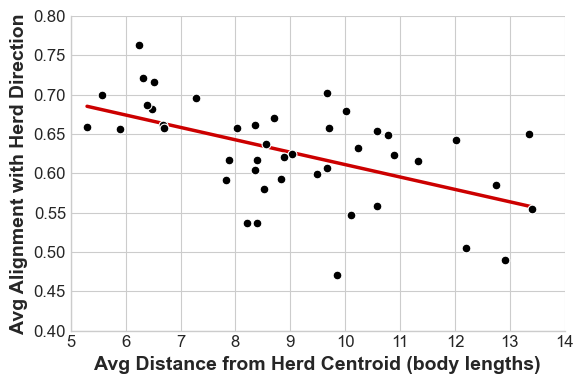

In [31]:
# Create a beautiful single-panel figure
fig, ax = plt.subplots(figsize=(6, 4))

# Create a custom color palette based on distance from center
norm = plt.Normalize(
    vmin=avg_distance_from_centroid.min().item(),
    vmax=avg_distance_from_centroid.max().item()
)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

# Primary scatter plot with black points
scatter = ax.scatter(
    avg_distance_from_centroid,
    avg_alignment,
    c='black',  # Set all points to black
    s=40,
    alpha=1,
    edgecolor='white',
    linewidth=0.8,
    zorder=10
)

# Add a trend line
valid_idx = ~np.isnan(avg_distance_from_centroid) & ~np.isnan(avg_alignment)
x_valid = avg_distance_from_centroid.values[valid_idx]
y_valid = avg_alignment.values[valid_idx]

if len(x_valid) > 2:
    # Create fit
    z = np.polyfit(x_valid, y_valid, 1)
    p = np.poly1d(z)
    x_range = np.linspace(min(x_valid), max(x_valid), 100)
    
    # Plot with confidence band
    ax.plot(x_range, p(x_range), '-', color='#cc0000', lw=2.5, zorder=5)
    
    # Add correlation
    corr = np.corrcoef(x_valid, y_valid)[0, 1]
    slope = z[0]
    
    # Add statistical annotation
    # stat_text = f"Correlation: {corr:.2f}\nSlope: {slope:.3f}"
    # ax.text(
    #     0.05, 0.95, 
    #     stat_text,
    #     transform=ax.transAxes,
    #     ha="left", va="top",
    #     bbox=dict(facecolor="white", alpha=0.8, boxstyle="round,pad=0.5"),
    #     fontsize=11
    # )

# # Add horizontal reference lines
# ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
# ax.axhline(y=0.7, color='gray', linestyle=':', alpha=0.5)
# ax.axhline(y=0.9, color='gray', linestyle=':', alpha=0.5)

# # Add annotations for alignment levels
# ax.text(ax.get_xlim()[1]*0.98, 0.51, "Moderate alignment", 
#         ha="right", va="bottom", color="gray", fontsize=9)
# ax.text(ax.get_xlim()[1]*0.98, 0.71, "Strong alignment", 
#         ha="right", va="bottom", color="gray", fontsize=9)
# ax.text(ax.get_xlim()[1]*0.98, 0.91, "Perfect alignment", 
#         ha="right", va="bottom", color="gray", fontsize=9)

# # Add binned data as larger transparent circles
# valid_bin_idx = ~np.isnan(alignment_by_bin)
# if sum(valid_bin_idx) > 0:
#     bin_x = bin_midpoints[valid_bin_idx]
#     bin_y = np.array(alignment_by_bin)[valid_bin_idx]
#     bin_counts = np.array(count_by_bin)[valid_bin_idx]
    
#     # Scale size by count but keep reasonable
#     size_scale = 600  # Base size for scaling
    
#     # Binned scatter with sizes based on count
#     bin_scatter = ax.scatter(
#         bin_x, bin_y,
#         s=bin_counts * size_scale / max(bin_counts) if max(bin_counts) > 0 else size_scale,
#         facecolor='none',
#         edgecolor='#1f77b4',
#         linewidth=2,
#         alpha=0.7,
#         zorder=8
#     )
    
#     # Add error bars
#     bin_err = np.array(alignment_stderr_by_bin)[valid_bin_idx]
#     ax.errorbar(
#         bin_x, bin_y,
#         yerr=bin_err,
#         fmt='none',
#         ecolor='#1f77b4',
#         elinewidth=1.5,
#         capsize=4,
#         alpha=0.7,
#         zorder=7
#     )

# # Add annotations based on the observed relationship
# if len(x_valid) > 2 and abs(corr) > 0.3:  # Only if correlation is meaningful
#     if corr < 0:  # Negative correlation
#         ax.annotate(
#             "Central zebras\nmore aligned with herd",
#             xy=(min(x_valid), max(y_valid)),
#             xytext=(min(x_valid) + (max(x_valid)-min(x_valid))*0.2, max(y_valid)),
#             arrowprops=dict(arrowstyle="->", color="black", alpha=0.7, lw=1.5),
#             fontsize=11,
#             bbox=dict(facecolor="white", alpha=0.8, boxstyle="round,pad=0.3"),
#             ha="center"
#         )
#         ax.annotate(
#             "Peripheral zebras\nless aligned with herd",
#             xy=(max(x_valid), min(y_valid)),
#             xytext=(max(x_valid) - (max(x_valid)-min(x_valid))*0.2, min(y_valid)),
#             arrowprops=dict(arrowstyle="->", color="black", alpha=0.7, lw=1.5),
#             fontsize=11,
#             bbox=dict(facecolor="white", alpha=0.8, boxstyle="round,pad=0.3"),
#             ha="center"
#         )
#     else:  # Positive correlation
#         ax.annotate(
#             "Central zebras\nless aligned with herd",
#             xy=(min(x_valid), min(y_valid)),
#             xytext=(min(x_valid) + (max(x_valid)-min(x_valid))*0.2, min(y_valid)),
#             arrowprops=dict(arrowstyle="->", color="black", alpha=0.7, lw=1.5),
#             fontsize=11,
#             bbox=dict(facecolor="white", alpha=0.8, boxstyle="round,pad=0.3"),
#             ha="center"
#         )
#         ax.annotate(
#             "Peripheral zebras\nmore aligned with herd",
#             xy=(max(x_valid), max(y_valid)),
#             xytext=(max(x_valid) - (max(x_valid)-min(x_valid))*0.2, max(y_valid)),
#             arrowprops=dict(arrowstyle="->", color="black", alpha=0.7, lw=1.5),
#             fontsize=11,
#             bbox=dict(facecolor="white", alpha=0.8, boxstyle="round,pad=0.3"),
#             ha="center"
#         )

# Labels and title
ax.set_xlabel("Avg Distance from Herd Centroid (body lengths)", fontsize=14, fontweight="bold")
ax.set_ylabel("Avg Alignment with Herd Direction", fontsize=14, fontweight="bold")
# ax.set_title("Zebra Alignment by Position in Herd", fontsize=18, fontweight="bold")

# # Legend for scatter sizes
# legend_elements = [
#     plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='none', markeredgecolor='#1f77b4',
#                markeredgewidth=2, markersize=8, label='Binned average'),
#     plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sm.cmap(0.2), markeredgecolor='white',
#                markeredgewidth=0.8, markersize=10, label='Individual zebras'),
#     plt.Line2D([0], [0], color='#cc0000', lw=2.5, label='Trend line')
# ]
# ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.5, -0.15), 
#           ncol=3, frameon=True, fontsize=11)

# Add colorbar
# cbar = plt.colorbar(sm, ax=ax, pad=0.02)
# cbar.set_label("Avg Distance from Centroid (body lengths)", fontsize=12, fontweight="bold")

# Clean up the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0.4, 0.8)
ax.set_xlim(5, 14)

plt.tight_layout()

# Save high resolution version for publication
save_publication_figure(fig, "zebra_alignment_by_position_in_herd", dpi=400)

Saved figure to figures/zebra_alignment_by_position_per_frame.pdf and figures/zebra_alignment_by_position_per_frame.png


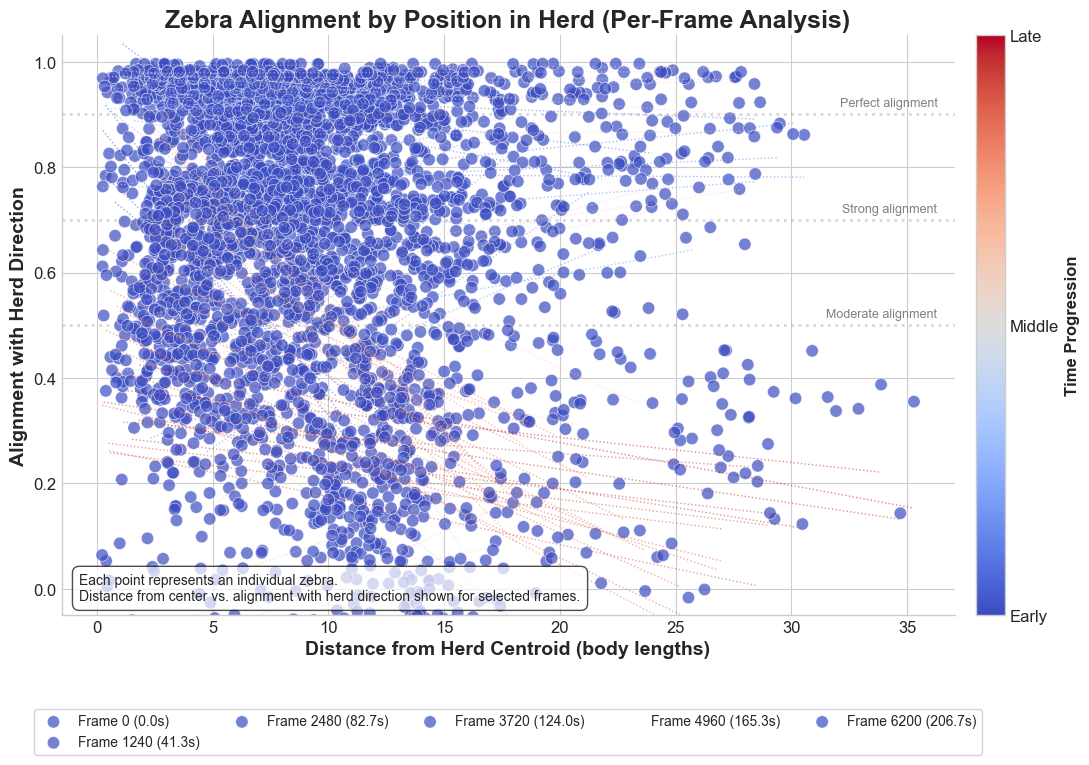

In [19]:
# Create a beautiful single-panel figure for per-frame analysis
fig, ax = plt.subplots(figsize=(12, 8))

# We'll analyze each individual's distance from herd centroid vs. alignment PER FRAME
# We'll display a subset of frames to avoid overcrowding
num_frames_total = len(centroid.time)
frame_step = max(1, num_frames_total // 100)  # Sample about 10 frames
frames_to_plot = np.arange(0, num_frames_total, frame_step)

# Create a diverging colormap for frames
frame_cmap = plt.cm.coolwarm

# Create empty lists to store data for legend
scatter_plots = []
frame_labels = []

# For each selected frame, plot alignment vs distance
for i, frame_idx in enumerate(frames_to_plot):
    if frame_idx >= num_frames_total:
        continue
        
    # Calculate distance from centroid for this frame
    frame_time = centroid.time.values[frame_idx]
    frame_centroid = herd_centroid.sel(time=frame_time)
    
    # Get individual positions at this frame
    frame_positions = centroid.sel(time=frame_time)
    
    # Calculate distance of each individual from centroid
    dists = []
    for ind in centroid.individuals.values:
        ind_pos = frame_positions.sel(individuals=ind)
        squared_diffs = (ind_pos - frame_centroid)**2
        dist = float(np.sqrt(squared_diffs.sum()))
        dists.append(dist)
    
    # Get alignment values for this frame
    frame_alignment = cos_body_vector.sel(time=frame_time)
    
    # Create scatter plot with color based on frame
    normalized_idx = i / len(frames_to_plot)
    sc = ax.scatter(
        dists,
        frame_alignment,
        c=[normalized_idx] * len(dists),
        cmap=frame_cmap,
        s=80,
        alpha=0.7,
        edgecolor='white',
        linewidth=0.5,
        label=f"Frame {frame_idx} ({frame_time:.1f}s)"
    )
    
    # Save scatter plot for legend
    if i % 2 == 0:  # Only add every other frame to legend to avoid overcrowding
        scatter_plots.append(sc)
        frame_labels.append(f"Frame {frame_idx} ({frame_time:.1f}s)")
    
    # Optional: Add a trend line for this frame
    valid_idx = ~np.isnan(dists) & ~np.isnan(frame_alignment)
    if sum(valid_idx) > 2:
        x_valid = np.array(dists)[valid_idx]
        y_valid = frame_alignment.values[valid_idx]
        z = np.polyfit(x_valid, y_valid, 1)
        p = np.poly1d(z)
        x_range = np.linspace(min(x_valid), max(x_valid), 10)
        ax.plot(x_range, p(x_range), ':', color=frame_cmap(normalized_idx), lw=1, alpha=0.5)

# Add horizontal reference lines
ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.3)
ax.axhline(y=0.7, color='gray', linestyle=':', alpha=0.3)
ax.axhline(y=0.9, color='gray', linestyle=':', alpha=0.3)

# Add annotations for alignment levels
ax.text(ax.get_xlim()[1]*0.98, 0.51, "Moderate alignment", 
        ha="right", va="bottom", color="gray", fontsize=9)
ax.text(ax.get_xlim()[1]*0.98, 0.71, "Strong alignment", 
        ha="right", va="bottom", color="gray", fontsize=9)
ax.text(ax.get_xlim()[1]*0.98, 0.91, "Perfect alignment", 
        ha="right", va="bottom", color="gray", fontsize=9)

# Labels and title
ax.set_xlabel("Distance from Herd Centroid (body lengths)", fontsize=14, fontweight="bold")
ax.set_ylabel("Alignment with Herd Direction", fontsize=14, fontweight="bold")
ax.set_title("Zebra Alignment by Position in Herd (Per-Frame Analysis)", fontsize=18, fontweight="bold")

# Create colorbar
norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap=frame_cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Time Progression", fontsize=12, fontweight="bold")
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels(["Early", "Middle", "Late"])

# Create a custom legend with fewer items to avoid overcrowding
if len(scatter_plots) > 5:
    # If too many items, select a few representative ones
    step = max(1, len(scatter_plots) // 5)
    scatter_plots = scatter_plots[::step]
    frame_labels = frame_labels[::step]

# Add legend showing a selection of frames
legend1 = ax.legend(scatter_plots, frame_labels,
                    loc="upper center", bbox_to_anchor=(0.5, -0.15),
                    ncol=min(5, len(scatter_plots)), fontsize=10, frameon=True)

# Clean up the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(-0.05, 1.05)

# Add text describing what the figure shows
ax.text(0.02, 0.02, 
        "Each point represents an individual zebra.\nDistance from center vs. alignment with herd direction shown for selected frames.",
        transform=ax.transAxes, fontsize=10, ha="left", va="bottom",
        bbox=dict(facecolor="white", alpha=0.7, boxstyle="round,pad=0.5"))

plt.tight_layout()
fig.subplots_adjust(bottom=0.22)  # Make space for the legend

# Save high resolution version for publication
save_publication_figure(fig, "zebra_alignment_by_position_per_frame", dpi=400)

## Summary Visualization

Let's create a summary dashboard that captures the key metrics of zebra herd behavior.

IndexError: boolean index did not match indexed array along axis 0; size of axis is 6294 but size of corresponding boolean axis is 44

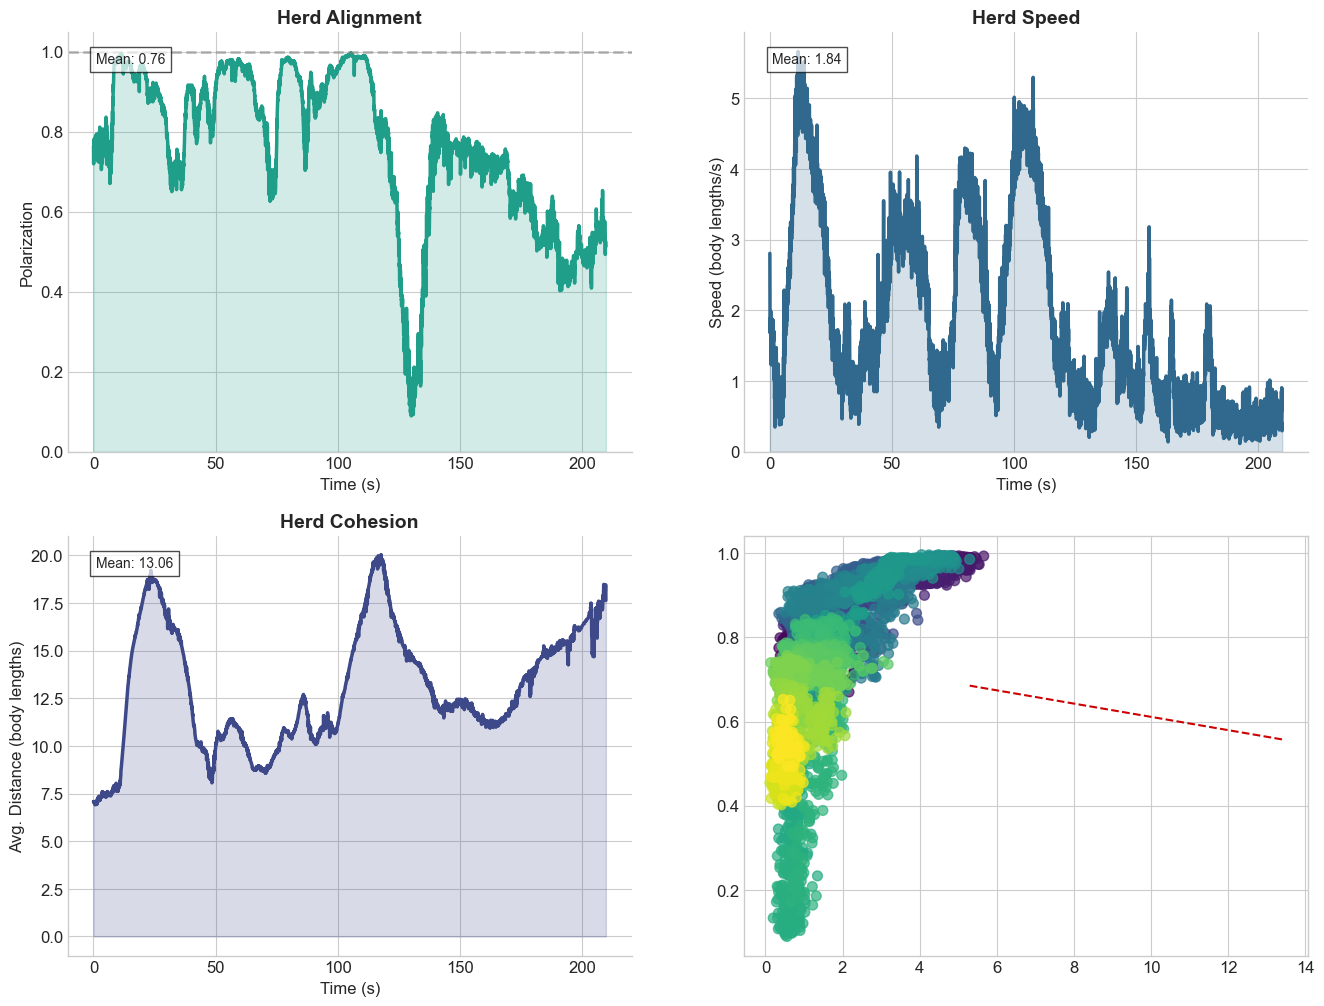

In [ ]:
# Create a cleaner multi-panel visualization summarizing zebra herd behavior
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

# Panel 1: Herd Polarization - simplified
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(polarisation.time, polarisation, lw=2.5, color=colors[4])
ax1.fill_between(polarisation.time, 0, polarisation, alpha=0.2, color=colors[4])
ax1.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax1.set_ylim(0, 1.05)
ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("Polarization", fontsize=12)
ax1.set_title("Herd Alignment", fontsize=14, fontweight="bold")
# Add only the mean as an annotation
ax1.text(0.05, 0.95, f"Mean: {float(polarisation.mean()):.2f}", transform=ax1.transAxes,
         ha="left", va="top", fontsize=10,
         bbox=dict(facecolor="white", alpha=0.7))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Panel 2: Speed - simplified
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(speed_avg.time, speed_avg, lw=2.5, color=colors[2])
ax2.fill_between(speed_avg.time, 0, speed_avg, alpha=0.2, color=colors[2])
ax2.set_ylim(bottom=0)
ax2.set_xlabel("Time (s)", fontsize=12)
ax2.set_ylabel("Speed (body lengths/s)", fontsize=12)
ax2.set_title("Herd Speed", fontsize=14, fontweight="bold")
# Add only the mean as an annotation
ax2.text(0.05, 0.95, f"Mean: {float(speed_avg.mean()):.2f}", transform=ax2.transAxes,
         ha="left", va="top", fontsize=10,
         bbox=dict(facecolor="white", alpha=0.7))
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Panel 3: Average Distance - simplified
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(mean_distance.time, mean_distance, lw=2.5, color=colors[1])
ax3.fill_between(mean_distance.time, 0, mean_distance, alpha=0.2, color=colors[1])
ax3.set_xlabel("Time (s)", fontsize=12)
ax3.set_ylabel("Avg. Distance (body lengths)", fontsize=12)
ax3.set_title("Herd Cohesion", fontsize=14, fontweight="bold")
# Add only the mean as an annotation
ax3.text(0.05, 0.95, f"Mean: {float(mean_distance.mean()):.2f}", transform=ax3.transAxes,
         ha="left", va="top", fontsize=10,
         bbox=dict(facecolor="white", alpha=0.7))
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# Panel 4: Polarization vs Speed Scatterplot - simplified
ax4 = fig.add_subplot(gs[1, 1])
sc = ax4.scatter(speed_avg, polarisation, c=point_colors, cmap="viridis", s=50, alpha=0.7)
# Add a simple trend line if possible
if np.sum(valid_idx) > 2:
    ax4.plot(x_range, p(x_range), '--', color="#cc0000", lw=1.5)
    # Add just correlation
    corr = np.corrcoef(speed_avg.values[valid_idx], polarisation.values[valid_idx])[0, 1]
    ax4.text(0.05, 0.95, f"Correlation: {corr:.2f}", transform=ax4.transAxes,
            ha="left", va="top", fontsize=10,
            bbox=dict(facecolor="white", alpha=0.7))
ax4.set_xlabel("Speed (body lengths/s)", fontsize=12)
ax4.set_ylabel("Polarization", fontsize=12)
ax4.set_title("Speed vs. Alignment", fontsize=14, fontweight="bold")
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

# Add a colorbar for the scatter points - simplified label
sm = plt.cm.ScalarMappable(cmap="viridis")
sm.set_array(point_colors)
cbar = plt.colorbar(sm, ax=ax4, pad=0.01)
cbar.set_label("Time", fontsize=10)

# Add a title for the entire figure
fig.suptitle(
    "Zebra Herd Behavior Analysis", 
    fontsize=18, 
    fontweight="bold",
    y=0.98
)

plt.tight_layout()
fig.subplots_adjust(top=0.92, wspace=0.25, hspace=0.3)

# Save high resolution version for publication
save_publication_figure(fig, "zebra_behavior_summary", dpi=400)

## Export All Figures for Publication

We can run this cell to export all figures again if needed.

In [ ]:
# Save all figures for the paper
print(f"All figures have been saved to {FIGURE_DIR}")
print(f"Vector format: {FIGURE_FORMAT}, Raster format: {FIGURE_FORMAT_WEB}")
print(f"DPI: {PUBLICATION_DPI}")

# List all files in the figures directory
print("\nSaved figures:")
for file in sorted(FIGURE_DIR.glob(f"*.{FIGURE_FORMAT}")):
    print(f"- {file.name}")

## Frame-Level Correlation Between Position and Alignment

Let's analyze if there's a correlation at the frame level between an individual zebra's distance from the herd centroid and its alignment with the herd. This will help us understand if peripheral animals tend to be more or less aligned with the group than those near the center, and how this relationship might change over time.

In [20]:
# Calculate the correlation between distance from centroid and alignment for each frame
frame_correlations = []
frame_times = []
frame_pvalues = []
frame_slopes = []

# Import stats module for p-values
from scipy import stats

# For each frame, calculate the correlation
for t_idx, t in enumerate(centroid.time):
    # Calculate distance from centroid for this frame
    frame_centroid = herd_centroid.sel(time=t)
    
    # Get individual positions at this frame
    frame_positions = centroid.sel(time=t)
    
    # Calculate distance of each individual from centroid
    dists = []
    for ind in centroid.individuals.values:
        ind_pos = frame_positions.sel(individuals=ind)
        squared_diffs = (ind_pos - frame_centroid)**2
        dist = float(np.sqrt(squared_diffs.sum()))
        dists.append(dist)
    
    # Get alignment values for this frame
    frame_alignment = cos_body_vector.sel(time=t).values
    
    # Calculate correlation if we have valid data
    valid_idx = ~np.isnan(dists) & ~np.isnan(frame_alignment)
    if sum(valid_idx) > 2:  # Need at least 3 points for meaningful correlation
        x_valid = np.array(dists)[valid_idx]
        y_valid = frame_alignment[valid_idx]
        
        # Calculate correlation coefficient and p-value
        corr, pval = stats.pearsonr(x_valid, y_valid)
        
        # Calculate slope of best fit line
        if len(x_valid) > 2:
            slope, _, _, _, _ = stats.linregress(x_valid, y_valid)
        else:
            slope = np.nan
        
        frame_correlations.append(corr)
        frame_pvalues.append(pval)
        frame_slopes.append(slope)
        frame_times.append(float(t))

# Create a beautiful figure showing the correlation over time
fig, ax = plt.subplots(figsize=(12, 8))

# Define a colormap based on statistical significance
significant = np.array(frame_pvalues) < 0.05
sizes = np.array([80 if sig else 40 for sig in significant])
colors = np.array(['#1f77b4' if sig else '#cccccc' for sig in significant])

# Create scatter plot of correlations over time
sc = ax.scatter(frame_times, frame_correlations, 
                s=sizes, 
                c=frame_correlations, 
                cmap='RdBu_r',
                vmin=-1, 
                vmax=1, 
                alpha=0.8,
                edgecolor='white',
                linewidth=0.5)

# Add a moving average trend line
window_size = max(5, len(frame_correlations) // 20)
if len(frame_correlations) > window_size:
    corr_array = np.array(frame_correlations)
    times_array = np.array(frame_times)
    
    # Simple moving average
    smoothed_corr = []
    smoothed_times = []
    
    for i in range(len(corr_array) - window_size + 1):
        window = corr_array[i:i+window_size]
        # Only compute average if we have enough non-nan values
        if np.sum(~np.isnan(window)) > window_size/2:
            smoothed_corr.append(np.nanmean(window))
            smoothed_times.append(times_array[i + window_size//2])
    
    # Plot the smoothed line
    ax.plot(smoothed_times, smoothed_corr, '-', color='black', lw=2, alpha=0.7, 
            label=f'Moving average (window={window_size})')

# Calculate fraction of frames with significant negative/positive correlations
sig_neg = np.sum((np.array(frame_correlations) < 0) & significant)
sig_pos = np.sum((np.array(frame_correlations) > 0) & significant)
total_sig = np.sum(significant)
total_frames = len(frame_correlations)

# Add statistics as text annotation
stats_text = f"Frames analyzed: {total_frames}\n"
stats_text += f"Significant correlations (p<0.05): {total_sig} frames ({total_sig/total_frames:.1%})\n"
stats_text += f"Negative correlations: {sig_neg} frames ({sig_neg/total_frames:.1%})\n"
stats_text += f"Positive correlations: {sig_pos} frames ({sig_pos/total_frames:.1%})"

ax.text(0.02, 0.98, stats_text,
        transform=ax.transAxes,
        ha="left", va="top",
        bbox=dict(facecolor="white", alpha=0.8, boxstyle="round,pad=0.5"),
        fontsize=10)

# Add horizontal reference lines
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.3)
ax.axhline(y=-0.5, color='gray', linestyle=':', alpha=0.3)

# Add annotations for correlation levels
ax.text(ax.get_xlim()[1], 0.5, "Strong positive\ncorrelation", 
        ha="right", va="bottom", color="gray", fontsize=9)
ax.text(ax.get_xlim()[1], -0.5, "Strong negative\ncorrelation", 
        ha="right", va="top", color="gray", fontsize=9)

# Add interpretation text - adjust based on the actual results
if sig_neg > sig_pos and sig_neg > total_frames * 0.1:  # If there are significant negative correlations
    ax.text(0.98, 0.02, 
            "Negative correlation suggests\ncentral zebras are more aligned\nwith the herd than peripheral ones",
            transform=ax.transAxes,
            ha="right", va="bottom",
            bbox=dict(facecolor="#d1ecf1", alpha=0.8, boxstyle="round,pad=0.5"),
            fontsize=10)
elif sig_pos > sig_neg and sig_pos > total_frames * 0.1:  # If there are significant positive correlations
    ax.text(0.98, 0.02, 
            "Positive correlation suggests\nperipheral zebras are more aligned\nwith the herd than central ones",
            transform=ax.transAxes,
            ha="right", va="bottom",
            bbox=dict(facecolor="#f8d7da", alpha=0.8, boxstyle="round,pad=0.5"),
            fontsize=10)
else:  # If correlations are mixed or not significant
    ax.text(0.98, 0.02, 
            "No consistent relationship between\nposition in herd and alignment",
            transform=ax.transAxes,
            ha="right", va="bottom",
            bbox=dict(facecolor="#fff3cd", alpha=0.8, boxstyle="round,pad=0.5"),
            fontsize=10)

# Add colorbar for correlation values
cbar = plt.colorbar(sc, ax=ax, pad=0.02)
cbar.set_label("Correlation Coefficient\n(Distance from Centroid vs. Alignment)", fontsize=12, fontweight="bold")

# Labels and title
ax.set_xlabel("Time (seconds)", fontsize=14, fontweight="bold")
ax.set_ylabel("Correlation Coefficient", fontsize=14, fontweight="bold")
ax.set_title("Frame-by-Frame Correlation: Position in Herd vs. Alignment", fontsize=16, fontweight="bold")

# Set y-axis limits
ax.set_ylim(-1.05, 1.05)

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#1f77b4', 
               markeredgecolor='white', markersize=10, label='Significant (p<0.05)'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#cccccc', 
               markeredgecolor='white', markersize=7, alpha=0.8, label='Not significant')
]
# Add the moving average line to legend if we have one
if len(frame_correlations) > window_size:
    legend_elements.append(plt.Line2D([0], [0], color='black', lw=2, alpha=0.7, 
                                      label=f'Moving average (window={window_size})'))

ax.legend(handles=legend_elements, loc='upper right', frameon=True)

# Clean up the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

# Save high resolution version for publication
save_publication_figure(fig, "zebra_frame_level_position_alignment_correlation", dpi=400)

KeyboardInterrupt: 